In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

from tensorflow.keras.layers import (
    Dense, Input, Layer, GlobalAveragePooling1D, LayerNormalization, 
    Lambda, Dropout, Reshape, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ============================================================
# 1. CUSTOM LAYERS (Preserved from your working version)
# ============================================================

class MultiHeadAttention(Layer):
    """Custom MHA for compatibility with older TF versions."""
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.d_model = num_heads * key_dim
        
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)
        self.combine_heads = Dense(self.d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, value, key):
        batch_size = tf.shape(query)[0]
        
        # Linear projections
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        
        # Reshape and combine heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        return self.combine_heads(output)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config


class VisionTemporalTransformer(Layer):
    def __init__(self, patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1, **kwargs):
        super(VisionTemporalTransformer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.spatial_layers = spatial_layers
        self.temporal_layers = temporal_layers

        self.dense_projection = Dense(d_model)
        self.pos_emb = None

        self.spatial_mhas = [MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(spatial_layers)]
        self.spatial_norm1 = [LayerNormalization() for _ in range(spatial_layers)]
        self.spatial_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(spatial_layers)]
        self.spatial_norm2 = [LayerNormalization() for _ in range(spatial_layers)]

        self.temporal_mhas = [MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(temporal_layers)]
        self.temporal_norm1 = [LayerNormalization() for _ in range(temporal_layers)]
        self.temporal_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(temporal_layers)]
        self.temporal_norm2 = [LayerNormalization() for _ in range(temporal_layers)]

    def build(self, input_shape):
        H = input_shape[2]
        W = input_shape[3]
        ph = H // self.patch_size
        pw = W // self.patch_size
        num_patches = ph * pw
        self.pos_emb = self.add_weight(shape=(1, num_patches, self.d_model), initializer='random_normal', trainable=True, name='pos_emb')
        super(VisionTemporalTransformer, self).build(input_shape)

    def call(self, inputs):
        # 1. Handle Shapes
        input_shape = inputs.get_shape() 
        shape = tf.shape(inputs)
        
        batch = shape[0]
        frames = shape[1]
        H = shape[2]
        W = shape[3]
        
        # Attempt to get static Channel dim
        C_static = input_shape[-1]
        C = C_static if C_static is not None else shape[4]

        # 2. Reshape
        reshaped = tf.reshape(inputs, (-1, H, W, C))

        # 3. Extract Patches
        patches = tf.image.extract_patches(
            images=reshaped,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        
        # 4. Flatten Patches & FORCE SHAPE
        if C_static is not None:
            patch_dim_static = self.patch_size * self.patch_size * C_static
        else:
            patch_dim_static = None
            
        patch_dim_dynamic = tf.shape(patches)[-1]
        final_patch_dim = patch_dim_static if patch_dim_static is not None else patch_dim_dynamic
        
        patches = tf.reshape(patches, (-1, tf.shape(patches)[1] * tf.shape(patches)[2], final_patch_dim))

        if patch_dim_static is not None:
             patches.set_shape([None, None, patch_dim_static])

        # 5. Projection
        x = self.dense_projection(patches) + self.pos_emb

        # 6. Spatial Transformer
        for i in range(self.spatial_layers):
            attn = self.spatial_mhas[i](x, value=x, key=x)
            x = self.spatial_norm1[i](x + attn)
            ff = self.spatial_ffn[i](x)
            x = self.spatial_norm2[i](x + ff)

        # 7. Temporal Pooling
        x = tf.reshape(x, (batch, frames, -1, self.d_model))
        x = tf.reduce_mean(x, axis=2)  

        # FORCE STATIC SHAPE FOR TEMPORAL (Required for older TF)
        x.set_shape([None, None, self.d_model]) 

        # 8. Temporal Transformer
        for i in range(self.temporal_layers):
            attn = self.temporal_mhas[i](x, value=x, key=x)
            x = self.temporal_norm1[i](x + attn)
            ff = self.temporal_ffn[i](x)
            x = self.temporal_norm2[i](x + ff)

        pooled = GlobalAveragePooling1D()(x)
        return pooled

    def get_config(self):
        config = super(VisionTemporalTransformer, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "spatial_layers": self.spatial_layers,
            "temporal_layers": self.temporal_layers,
        })
        return config

# ============================================================
# 2. MODEL DEFINITION
# ============================================================

def batch_consistency_loss(y_true, features):
    f = tf.reshape(features, (tf.shape(features)[0], -1))
    f_norm = tf.math.l2_normalize(f, axis=1)
    sim_matrix = tf.matmul(f_norm, f_norm, transpose_b=True)
    avg_sim = tf.reduce_mean(sim_matrix, axis=1)
    return 1.0 - avg_sim

def consistency_loss_wrapper(y_true, y_pred):
    return batch_consistency_loss(y_true, y_pred)

def build_lipinc_model(frame_shape=(8,64,144,3), residue_shape=(7,64,144,3), d_model=128):
    frame_input = Input(shape=frame_shape, name='FrameInput')
    residue_input = Input(shape=residue_shape, name='ResidueInput')

    vt = VisionTemporalTransformer(
        patch_size=8, d_model=d_model, num_heads=4, spatial_layers=1, temporal_layers=1
    )

    frame_feat = vt(frame_input)      
    residue_feat = vt(residue_input) 

    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)
    k = expand1(residue_feat)
    v = k

    mha = MultiHeadAttention(num_heads=4, key_dim=d_model//4)
    attn_out = mha(q, value=v, key=k)  

    squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))
    attn_out = squeeze(attn_out)

    concat = Lambda(lambda t: tf.concat(t, axis=1))
    fusion = concat([frame_feat, residue_feat, attn_out])

    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)

    class_output = Dense(2, activation='softmax', name='class_output')(x)
    features_output = Dense(d_model, activation=None, name='features_output')(x)

    model = Model(
        inputs=[frame_input, residue_input],
        outputs=[class_output, features_output],
        name='LIPINC_fixed'
    )
    return model

print("Model architecture loaded.")

Model architecture loaded.


In [2]:
class VideoDataGenerator(tf.keras.utils.Sequence):
    """
    Custom Data Generator to load videos in batches, avoiding RAM crashes.
    """
    def __init__(self, video_paths, labels, batch_size=16, frame_count=8, dim=(64, 144), shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_paths = [self.video_paths[k] for k in indexes]
        list_labels = [self.labels[k] for k in indexes]

        return self.__data_generation(list_paths, list_labels)

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        try:
            while len(frames) < self.frame_count:
                ret, frame = cap.read()
                if not ret:
                    break
                # Resize to (W, H) -> cv2 uses (width, height)
                # Model expects (64, 144) -> Height 64, Width 144
                frame = cv2.resize(frame, (self.dim[1], self.dim[0])) 
                frames.append(frame)
        finally:
            cap.release()

        frames = np.array(frames)
        
        # Handle empty/short videos
        if len(frames) == 0:
            return np.zeros((self.frame_count, self.dim[0], self.dim[1], 3), dtype=np.float32)
            
        if len(frames) < self.frame_count:
            # Pad with zeros
            padding = np.zeros((self.frame_count - len(frames), self.dim[0], self.dim[1], 3))
            frames = np.concatenate([frames, padding], axis=0)
            
        return frames.astype(np.float32) / 255.0

    def compute_residue(self, frames):
        # Simple residue: frame[t] - frame[t-1]
        residues = np.zeros((self.frame_count - 1, self.dim[0], self.dim[1], 3), dtype=np.float32)
        if len(frames) > 1:
            for i in range(1, len(frames)):
                residues[i-1] = frames[i] - frames[i-1]
        return residues

    def __data_generation(self, list_paths, list_labels):
        # Initialization
        X_frames = np.empty((self.batch_size, self.frame_count, *self.dim, 3))
        X_residues = np.empty((self.batch_size, self.frame_count-1, *self.dim, 3))
        y = np.empty((self.batch_size, 2), dtype=int)
        
        # Dummy target for consistency loss
        dummy_feats = np.zeros((self.batch_size, 128))

        for i, path in enumerate(list_paths):
            frames = self.load_video(path)
            X_frames[i,] = frames
            X_residues[i,] = self.compute_residue(frames)
            y[i] = list_labels[i]

        # Inputs: [FrameInput, ResidueInput]
        # Outputs: {'class_output': y, 'features_output': dummy}
        return [X_frames, X_residues], {'class_output': y, 'features_output': dummy_feats}

In [3]:
import pandas as pd
import json
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------
# 1. SETUP PATHS
# -----------------------------------------------------------
# Dataset 1: DFD
DFD_REAL_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
DFD_FAKE_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences"

# Dataset 2: DFDC
DFDC_PATH = "/kaggle/input/deepfake-detection-challenge/train_sample_videos"
DFDC_METADATA = os.path.join(DFDC_PATH, "metadata.json")

# Dataset 3: FaceForensics++ (Real)
FF_REAL_PATH = "/kaggle/input/ff-c23/FaceForensics++_C23/original"

# Dataset 3: FaceForensics++ (Fakes)
FF_FAKE_PATHS = [
    "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes",
    "/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face",
    "/kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap",
    "/kaggle/input/ff-c23/FaceForensics++_C23/NeuralTextures"
]

# -----------------------------------------------------------
# 2. LOAD DATASETS
# -----------------------------------------------------------
print("Scanning Datasets...")

# --- DFD ---
dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.mp4'), recursive=True)
dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.mp4'), recursive=True)
# Fallback
if not dfd_real: dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.avi'), recursive=True)
if not dfd_fake: dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.avi'), recursive=True)

# --- DFDC ---
dfdc_real, dfdc_fake = [], []
if os.path.exists(DFDC_METADATA):
    with open(DFDC_METADATA, 'r') as f:
        metadata = json.load(f)
    for filename, meta in metadata.items():
        full_path = os.path.join(DFDC_PATH, filename)
        if os.path.exists(full_path):
            if meta['label'] == 'REAL': dfdc_real.append(full_path)
            else: dfdc_fake.append(full_path)

# --- FaceForensics++ (Real) ---
ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.mp4'), recursive=True)
if not ff_real: ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.avi'), recursive=True)

# --- FaceForensics++ (Fakes) ---
ff_fake = []
for path in FF_FAKE_PATHS:
    fakes = glob(os.path.join(path, '**', '*.mp4'), recursive=True)
    if not fakes: fakes = glob(os.path.join(path, '**', '*.avi'), recursive=True)
    ff_fake.extend(fakes)

print(f"Counts -> DFD: {len(dfd_real)}/{len(dfd_fake)} | DFDC: {len(dfdc_real)}/{len(dfdc_fake)} | FF++: {len(ff_real)}/{len(ff_fake)}")

# -----------------------------------------------------------
# 3. AGGREGATE & BALANCE DATA
# -----------------------------------------------------------
# Combine all sources
all_real_paths = np.array(dfd_real + dfdc_real + ff_real)
all_fake_paths = np.array(dfd_fake)

n_real = len(all_real_paths)
n_fake = len(all_fake_paths)

print(f"Only using DFD dataset for Fake Videos")
print(f"Total Available -> Real: {n_real}, Fake: {n_fake}")

# Undersample Fake to match Real
if n_fake > n_real:
    print(f"Undersampling Fake videos from {n_fake} to {n_real}...")
    undersampled_fake_paths = np.random.choice(all_fake_paths, n_real, replace=False)
    final_fake_paths = undersampled_fake_paths
else:
    # If we have more real than fake (or 0 fakes), keep all fakes
    final_fake_paths = all_fake_paths

final_real_paths = all_real_paths

# Create Labels
final_real_labels = [[1, 0]] * len(final_real_paths)
final_fake_labels = [[0, 1]] * len(final_fake_paths)

# -----------------------------------------------------------
# 4. MERGE (FIXED)
# -----------------------------------------------------------
# Merge Paths (Numpy arrays)
all_paths = np.concatenate([final_real_paths, final_fake_paths])

# Merge Labels (Lists -> Single Numpy Array)
all_labels = np.array(final_real_labels + final_fake_labels)

print(f"Final Balanced Dataset: {len(all_paths)} total videos ({len(final_real_paths)} Real, {len(final_fake_paths)} Fake)")

if len(all_paths) == 0:
    raise ValueError("No videos found! Check your dataset paths.")

# -----------------------------------------------------------
# 5. SPLIT DATA
# -----------------------------------------------------------
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training on: {len(X_train_paths)}")
print(f"Validation on: {len(X_val_paths)}")
print(f"Testing on: {len(X_test_paths)}")

# -----------------------------------------------------------
# 6. INSTANTIATE GENERATORS
# -----------------------------------------------------------
BATCH_SIZE = 16

train_gen = VideoDataGenerator(X_train_paths, y_train, batch_size=BATCH_SIZE)
val_gen = VideoDataGenerator(X_val_paths, y_val, batch_size=BATCH_SIZE)
test_gen = VideoDataGenerator(X_test_paths, y_test, batch_size=BATCH_SIZE, shuffle=False)

Scanning Datasets...
Counts -> DFD: 363/3068 | DFDC: 77/323 | FF++: 1000/4000
Only using DFD dataset for Fake Videos
Total Available -> Real: 1440, Fake: 3068
Undersampling Fake videos from 3068 to 1440...
Final Balanced Dataset: 2880 total videos (1440 Real, 1440 Fake)
Training on: 2016
Validation on: 432
Testing on: 432


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Build Model
model = build_lipinc_model()
model.summary()

# Compile
opt = Adam(learning_rate=1e-5) # Slightly lower LR for stability
model.compile(
    optimizer=opt,
    loss={
        'class_output': 'categorical_crossentropy',
        'features_output': consistency_loss_wrapper
    },
    loss_weights={
        'class_output': 1.0,
        'features_output': 1.0
    },
    metrics={'class_output': 'accuracy'}
)

# -----------------------------------------------------------
# DEFINE CALLBACKS
# -----------------------------------------------------------
# 1. Save only the best model (in case performance drops later)
checkpoint = ModelCheckpoint(
    'best_lipinc_model.h5', 
    monitor='val_class_output_accuracy', # specifically monitor the classification accuracy
    save_best_only=True, 
    mode='max',
    verbose=1
)

# 2. Stop training if it stops improving for 5 epochs
early_stop = EarlyStopping(
    monitor='val_class_output_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# -----------------------------------------------------------
# TRAIN
# -----------------------------------------------------------
print("Starting Training on Full Dataset...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, early_stop], # Added callbacks list
    verbose=1
)

# Save the final state as well
model.save('lipinc_full_data_final.h5')
print("Model saved.")

Model: "LIPINC_fixed"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
FrameInput (InputLayer)         [(None, 8, 64, 144,  0                                            
__________________________________________________________________________________________________
ResidueInput (InputLayer)       [(None, 7, 64, 144,  0                                            
__________________________________________________________________________________________________
vision_temporal_transformer (Vi (None, 128)          439680      FrameInput[0][0]                 
                                                                 ResidueInput[0][0]               
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1, 128)       0           vision_temporal_transf

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, jaccard_score, accuracy_score

print("\nEvaluating on Test Set...")
# 1. Standard Keras Evaluate (Loss & Accuracy)
results = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[-1]:.4f}")

# 2. Detailed Metrics Calculation
print("Calculating AP, AUC, and IoU...")
y_true_all = []
y_pred_all = []

# Reset generator to ensure we start from the beginning
test_gen.on_epoch_end()

# Loop through the generator to gather all predictions
for i in range(len(test_gen)):
    inputs, targets = test_gen[i]
    
    # Extract True Labels (One-hot encoded)
    y_true_batch = targets['class_output']
    
    # Get Predictions
    preds = model.predict_on_batch(inputs)
    # preds is a list [class_output, features_output], we need class_output (index 0)
    y_pred_batch = preds[0] 
    
    y_true_all.extend(y_true_batch)
    y_pred_all.extend(y_pred_batch)

# Convert to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Extract probabilities for the "Fake" class (Index 1)
# y_true_all is shape (N, 2) -> [Real, Fake]
# y_pred_all is shape (N, 2) -> [Prob_Real, Prob_Fake]
true_labels = y_true_all[:, 1]
pred_probs = y_pred_all[:, 1]

# Convert probabilities to hard binary labels (0 or 1) for IoU calculation
# Threshold is usually 0.5
pred_labels = (pred_probs > 0.5).astype(int)

try:
    # 1. ROC-AUC
    roc_auc = roc_auc_score(true_labels, pred_probs)
    
    # 2. Average Precision (AP)
    ap_score = average_precision_score(true_labels, pred_probs)
    
    # 3. Intersection over Union (IoU) - Equivalent to Jaccard Score for binary classification
    # Calculates: TP / (TP + FP + FN)
    iou_score = jaccard_score(true_labels, pred_labels, average='binary')

    print("-" * 30)
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print(f"AP Score : {ap_score:.4f}")
    print(f"IoU Score: {iou_score:.4f}")
    print("-" * 30)
    
except Exception as e:
    print("Error calculating metrics (Check if test set has both classes):", e)


Evaluating on Test Set...
27/27 [==============================] - 37s 1s/step - loss: 0.3371 - class_output_loss: 0.3357 - features_output_loss: 0.0014 - class_output_accuracy: 0.8542
Test Loss: 0.3371
Test Accuracy: 0.8542
Calculating AP, AUC, and IoU...
------------------------------
ROC-AUC  : 0.9256
AP Score : 0.8889
IoU Score: 0.7675
------------------------------


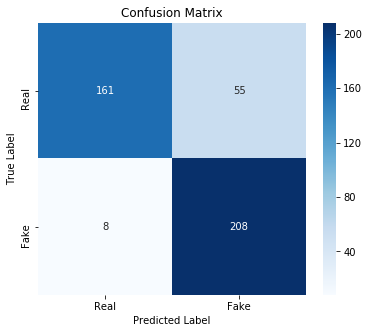


--- Classification Report ---
              precision    recall  f1-score   support

        Real       0.95      0.75      0.84       216
        Fake       0.79      0.96      0.87       216

    accuracy                           0.85       432
   macro avg       0.87      0.85      0.85       432
weighted avg       0.87      0.85      0.85       432



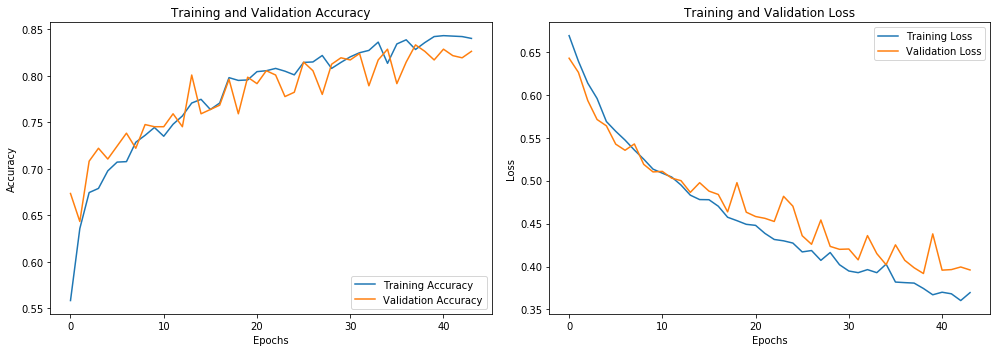

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================
# 1. Confusion Matrix & Classification Report
# ==========================================

# Ensure variables from the previous cell are available
# true_labels: 1D array of actual class indices (0 or 1)
# pred_labels: 1D array of predicted class indices (0 or 1)

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
print("\n--- Classification Report ---")
print(classification_report(true_labels, pred_labels, target_names=['Real', 'Fake']))

# ==========================================
# 2. Training History Plots
# ==========================================

# We plot the specific loss and accuracy for the 'class_output' head
acc = history.history['class_output_accuracy']
val_acc = history.history['val_class_output_accuracy']

loss = history.history['class_output_loss']
val_loss = history.history['val_class_output_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()